Імпорт модулів та бази даних:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/python

events = pd.read_csv("events.csv")
countries = pd.read_csv("countries.csv")
products = pd.read_csv("products.csv")

Mounted at /content/drive
/content/drive/MyDrive/python


Основна інформація по таблицям:

In [3]:
print(events.info())
print(countries.info())
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        1330 non-null   int64  
 1   Order Date      1330 non-null   object 
 2   Ship Date       1330 non-null   object 
 3   Order Priority  1330 non-null   object 
 4   Country Code    1248 non-null   object 
 5   Product ID      1330 non-null   int64  
 6   Sales Channel   1330 non-null   object 
 7   Units Sold      1328 non-null   float64
 8   Unit Price      1330 non-null   float64
 9   Unit Cost       1330 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 104.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        249 non-null    object
 1   alpha-2     248 non-null    object
 2   alpha-3     249

Надаю колонкам Order Date, Ship Date відповідний тип даних:

In [4]:
events["Order Date"] = pd.to_datetime(events["Order Date"])
events["Ship Date"] = pd.to_datetime(events["Ship Date"])

Нижче шукаю NaN значення:

In [5]:
print(events.isna().sum())

Order ID           0
Order Date         0
Ship Date          0
Order Priority     0
Country Code      82
Product ID         0
Sales Channel      0
Units Sold         2
Unit Price         0
Unit Cost          0
dtype: int64


In [ ]:
print(countries.isna().sum())

name          0
alpha-2       1
alpha-3       0
region        1
sub-region    1
dtype: int64


In [ ]:
print(products.isna().sum())

id           0
item_type    0
dtype: int64


Об'єдную таблиці в одну:

In [6]:
join = pd.merge(events, countries, left_on="Country Code", right_on="alpha-3", how="left")
df = pd.merge(join, products, left_on="Product ID", right_on = "id", how="inner")

Тут бачимо інформацію по рядкам де є NaN, так як вони містять значну частку загального обсягу продажів, вирішила їх зберегти і використовувати в подальшому аналізі.

In [7]:
nans = df[df["Country Code"].isna()]
nans.describe()

,Order ID,Order Date,Ship Date,Product ID,Units Sold,Unit Price,Unit Cost,id
count,8.200000e+01,82,82,82.000000,82.000000,82.000000,82.000000,82.000000
mean,5.173120e+08,2013-10-16 19:54:08.780487680,2013-11-09 06:26:20.487804928,6268.390244,4937.231707,275.699634,200.908902,6268.390244
min,1.010260e+08,2010-01-13 00:00:00,2010-01-20 00:00:00,1270.000000,35.000000,9.330000,6.920000,1270.000000
25%,2.942533e+08,2012-03-07 06:00:00,2012-03-27 00:00:00,4594.000000,2460.500000,81.730000,56.670000,4594.000000
50%,5.093887e+08,2013-11-20 12:00:00,2013-12-06 12:00:00,7331.000000,4826.000000,154.060000,97.440000,7331.000000
75%,7.613631e+08,2015-05-07 18:00:00,2015-06-04 12:00:00,8681.000000,7241.000000,437.200000,364.690000,8681.000000
max,9.891028e+08,2017-07-23 00:00:00,2017-08-20 00:00:00,8969.000000,9929.000000,668.270000,524.960000,8969.000000
std,2.576570e+08,NaN,NaN,2684.018255,2755.612998,230.232263,186.872149,2684.018255


Перевіряю базу даних на наявність дублікатів, стандартизую текст:

In [8]:
df.duplicated().sum()
df = df.apply(lambda col: col.str.strip().str.capitalize() if col.dtype == "object" else col)

Працюю з фінальним виглядом таблиці - прибираю непотрібні колонки, перейменовую, створюю нові для подальшого аналізу:

In [9]:

df= df.drop(columns=["Order Priority", "Country Code", "Product ID", "alpha-2", "alpha-3", "id"])
df.rename(columns={"name": "Country", "item_type": "Product Type"}, inplace=True)
df["Year"] = df["Order Date"].dt.year
df["Month_year"] = df["Order Date"].dt.strftime("%m.%Y")
df["Month name"] = df["Order Date"].dt.strftime("%B")
df["Weekday"] = df["Order Date"].dt.day_name()
df["Delivery"] = df["Ship Date"] - df["Order Date"]
df["Profit"] = (df["Unit Price"] - df["Unit Cost"])*df["Units Sold"]
df["Country"] = df["Country"].fillna("Not Defined")
df["Revenue"] = df["Unit Price"] * df["Units Sold"]
df["Cost"] = df["Unit Cost"] * df["Units Sold"]

from pandas.api.types import CategoricalDtype
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_type = CategoricalDtype(categories=month_order, ordered=True)
df["Month name"] = df["Month name"].astype(month_type)

df["Month_year"] = pd.to_datetime(df["Month_year"], format="%m.%Y")

In [ ]:
df.head()

,Order ID,Order Date,Ship Date,Sales Channel,Units Sold,Unit Price,Unit Cost,Country,region,sub-region,Product Type,Year,Month_year,Month name,Weekday,Delivery,Profit,Revenue,Cost
0,100640618,2014-10-08,2014-10-18,Online,650.00,205.70,117.11,Norway,Europe,Northern europe,Cereal,2014,2014-10-01,October,Wednesday,10 days,"57,583.50","133,705.00","76,121.50"
1,100983083,2016-08-11,2016-08-11,Offline,"1,993.00",205.70,117.11,Serbia,Europe,Southern europe,Cereal,2016,2016-08-01,August,Thursday,0 days,"176,559.87","409,960.10","233,400.23"
2,101025998,2014-07-18,2014-08-11,Online,"4,693.00",668.27,502.54,Not Defined,NaN,NaN,Household,2014,2014-07-01,July,Friday,24 days,"777,770.89","3,136,191.11","2,358,420.22"
3,102230632,2017-05-13,2017-06-13,Online,"1,171.00",109.28,35.84,Montenegro,Europe,Southern europe,Clothes,2017,2017-05-01,May,Saturday,31 days,"85,998.24","127,966.88","41,968.64"
4,103435266,2012-08-11,2012-09-18,Offline,"7,648.00",47.45,31.79,Serbia,Europe,Southern europe,Beverages,2012,2012-08-01,August,Saturday,38 days,"119,767.68","362,897.60","243,129.92"


In [10]:
df["Order Date"].min()

Timestamp('2010-01-01 00:00:00')

Рахуємо основні метрики діяльності компанії:

In [11]:
total_sales = (df["Revenue"]).sum()
total_profit = df["Profit"].sum()
orders_count = df["Order ID"].count()
units_sold = df["Units Sold"].sum()
avg_price =  df["Unit Price"].mean()
countries = df.loc[df["Country"] != "Not Defined", "Country"].nunique()

In [12]:
pd.set_option('display.float_format', '{:,.2f}'.format)

Виводжу продажі в розрізі категорій та каналу продажів, прибуток - в розрізі категорій, країн, регіонів, також виводжу найпопулярніші категорії товарів в топ 10 країн по продажам:

In [ ]:
categories_sales = df.groupby("Product Type")[["Revenue"]].sum()
categories_sales = categories_sales.sort_values(by="Revenue", ascending=False)

categories_profit = df.groupby("Product Type")[["Profit"]].sum()
categories_profit = categories_profit.sort_values(by="Profit", ascending=False)

countries_profit = df.groupby("Country")[["Profit"]].sum()
countries_profit = countries_profit.sort_values(by="Profit", ascending=False)

region_profit = df.groupby("region")[["Profit"]].sum()
region_profit = region_profit.sort_values(by="Profit", ascending = False)

top_countries = df.groupby("Country")[["Revenue"]].sum()
top_countries = top_countries.sort_values(by="Revenue", ascending = False).head(10).index
top_df = df[df["Country"].isin(top_countries)]
top_category_per_country = (top_df.groupby(["Country", "Product Type"])["Revenue"].sum().reset_index())
top_category_per_country = top_category_per_country.sort_values("Revenue", ascending=False)
top_category_per_country = top_category_per_country.drop_duplicates(subset=["Country"])

channel = df.groupby("Sales Channel")[["Revenue"]].sum()


Рахую середній час на доставку по країнам, підрегіонам, та категоріям, також рахую чи впливає час відвантаження товару на продажі:

In [ ]:
countries_ship = df.groupby("Country")[["Delivery"]].mean()

subregion_ship = df.groupby("sub-region")[["Delivery"]].mean()

category_ship = df.groupby("Product Type")[["Delivery"]].mean()

df["Delivery Days"] = (df["Ship Date"] - df["Order Date"]).dt.days
df["Delivery Group"] = pd.cut(df["Delivery Days"],bins=[-1, 10, 20, float("inf")],labels=["0-10 days", "11-20 days", "21+ days"])
delivery_stats = (df.groupby("Delivery Group")["Revenue"].mean().reset_index().rename(columns={"Revenue": "Average Revenue"}))

Окремо виводжу динаміку продажів по місяцям та рокам:

In [ ]:
profit_by_years = df.groupby("Year")[["Profit"]].sum()
sales_by_month = df.groupby("Month name")[["Revenue"]].sum()
profit_dynamics = df.groupby("Month_year")[["Profit"]].sum()

Виводжу помісячну динаміку продажів для кожної категорії:

In [ ]:
cereal = df[df["Product Type"] == "Cereal"].groupby("Month name")["Revenue"].sum()
household = df[df["Product Type"] == "Household"].groupby("Month name")["Revenue"].sum()
clothes = df[df["Product Type"] == "Clothes"].groupby("Month name")["Revenue"].sum()
beverages = df[df["Product Type"] == "Beverages"].groupby("Month name")["Revenue"].sum()
office_supplies = df[df["Product Type"] == "Office supplies"].groupby("Month name")["Revenue"].sum()
fruits = df[df["Product Type"] == "Fruits"].groupby("Month name")["Revenue"].sum()
vegetables = df[df["Product Type"] == "Vegetables"].groupby("Month name")["Revenue"].sum()
baby_food = df[df["Product Type"] == "Baby Food"].groupby("Month name")["Revenue"].sum()
meat = df[df["Product Type"] == "Meat"].groupby("Month name")["Revenue"].sum()
cosmetics = df[df["Product Type"] == "Cosmetics"].groupby("Month name")["Revenue"].sum()
snacks = df[df["Product Type"] == "Snacks"].groupby("Month name")["Revenue"].sum()
personal_care = df[df["Product Type"] == "Personal care"].groupby("Month name")["Revenue"].sum()

Динаміка для регіонів:


In [ ]:
regions = df.groupby(["region", "Month name"])[["Revenue"]].sum()

Кількість замовлень по дням тижня:

In [ ]:
weekday = df.groupby("Weekday")["Order ID"].count()
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
week_type = CategoricalDtype(categories=week_order, ordered=True)
df["Weekday"] = df["Weekday"].astype(week_type)

In [ ]:
profit_by_years = df.groupby("Year")[["Profit"]].sum()
sales_by_month = df.groupby("Month name")[["Revenue"]].sum()
profit_dynamics = df.groupby("Month_year")[["Profit"]].sum()

Візуалізація даних:

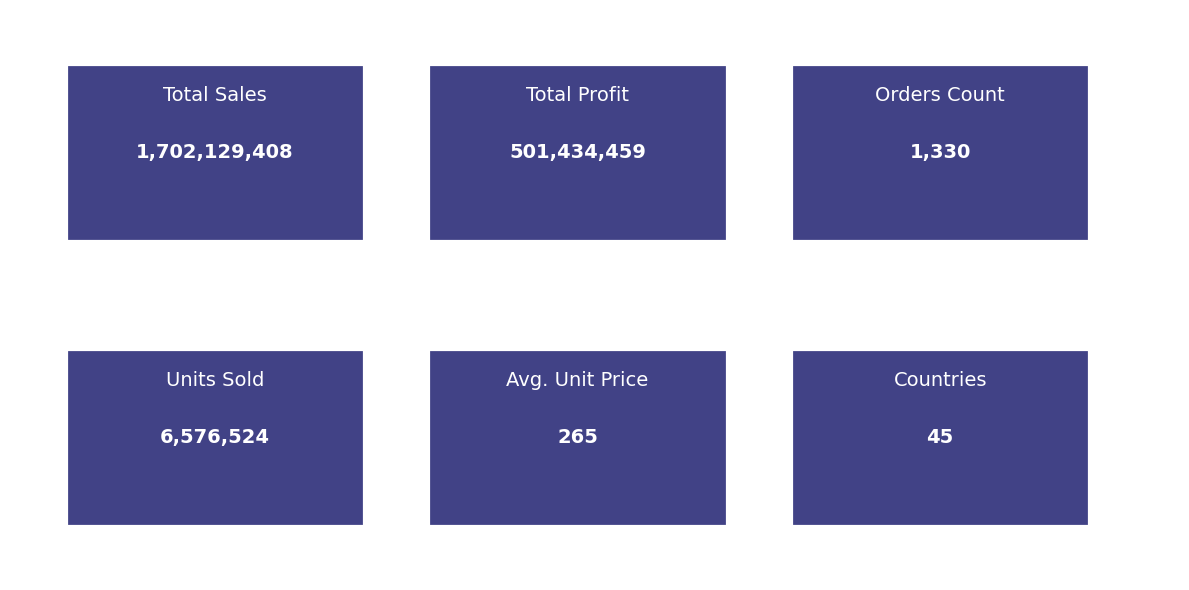

In [ ]:
metrics = {
    "Total Sales": total_sales,
    "Total Profit": total_profit,
    "Orders Count": orders_count,
    "Units Sold": units_sold,
    "Avg. Unit Price": avg_price,
    "Countries": countries
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")

x_start = 0.05
width = 0.25
gap = 0.06

for i, (key, value) in enumerate(metrics.items()):
    x_pos = x_start + (i % 3) * (width + gap)
    y_pos = 0.6 if i < 3 else 0.1
    ax.add_patch(plt.Rectangle((x_pos, y_pos), width, 0.3, color="#414286", lw=2))
    ax.text(x_pos + width / 2, y_pos + 0.25, key, ha="center", va="center", fontsize=14, color="white")
    ax.text(x_pos + width / 2, y_pos + 0.15, f"{value:,.0f}", ha="center", va="center", fontsize=14, color="white", weight="bold")

plt.tight_layout()
plt.show()


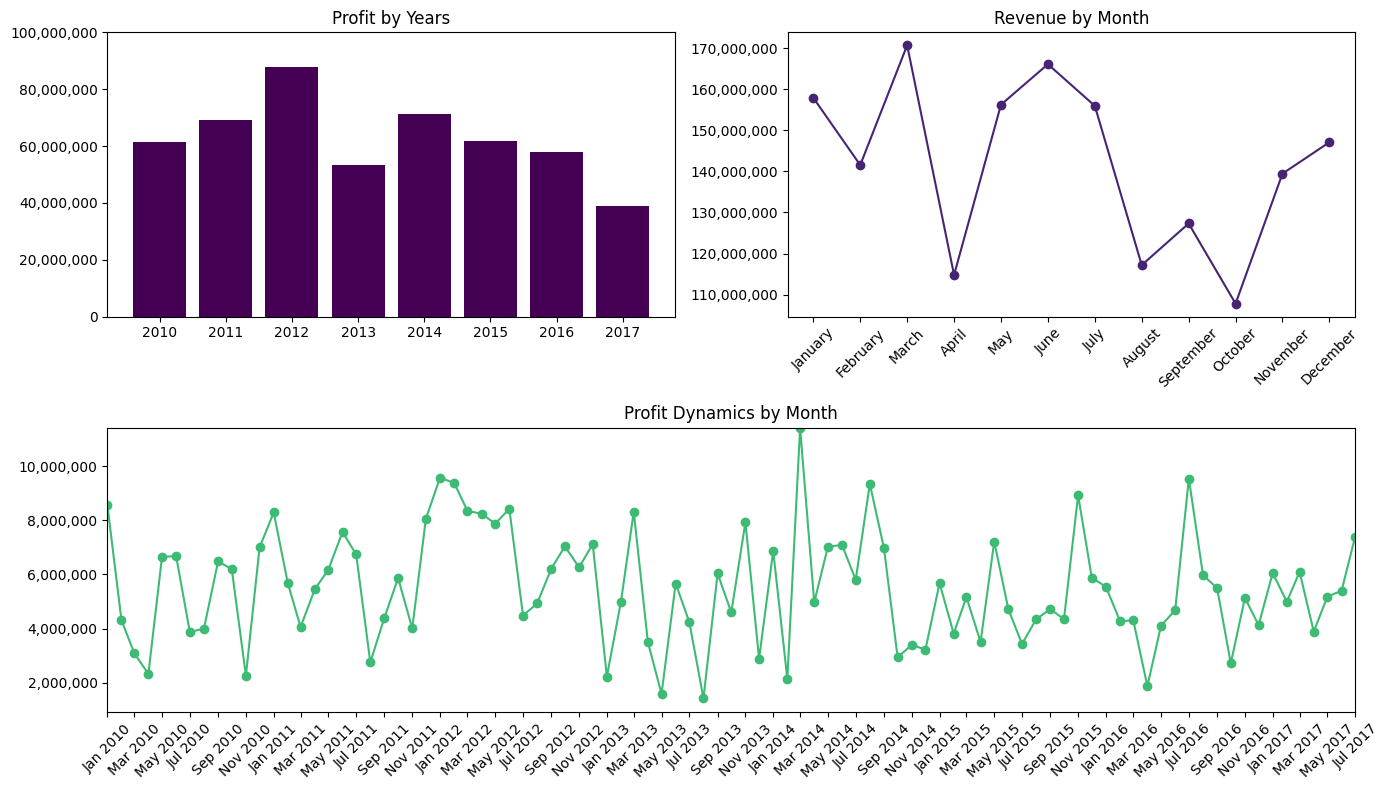

In [ ]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(profit_by_years.index, profit_by_years["Profit"], color='#440154')
ax1.set_title("Profit by Years")
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax1.set_ylim(top=max(profit_by_years["Profit"].max(), 100000000))


ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sales_by_month.index, sales_by_month["Revenue"], marker='o', color='#482374')
ax2.set_title("Revenue by Month")
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


ax3 = fig.add_subplot(gs[1, :])
ax3.plot(profit_dynamics.index, profit_dynamics["Profit"], marker='o', color='#3dbb74')
ax3.set_title("Profit Dynamics by Months")
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax3.set_ylim(top=max(profit_dynamics["Profit"].max(), 2000000))


ax3.set_xlim(left=profit_dynamics.index.min(), right=profit_dynamics.index.max())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

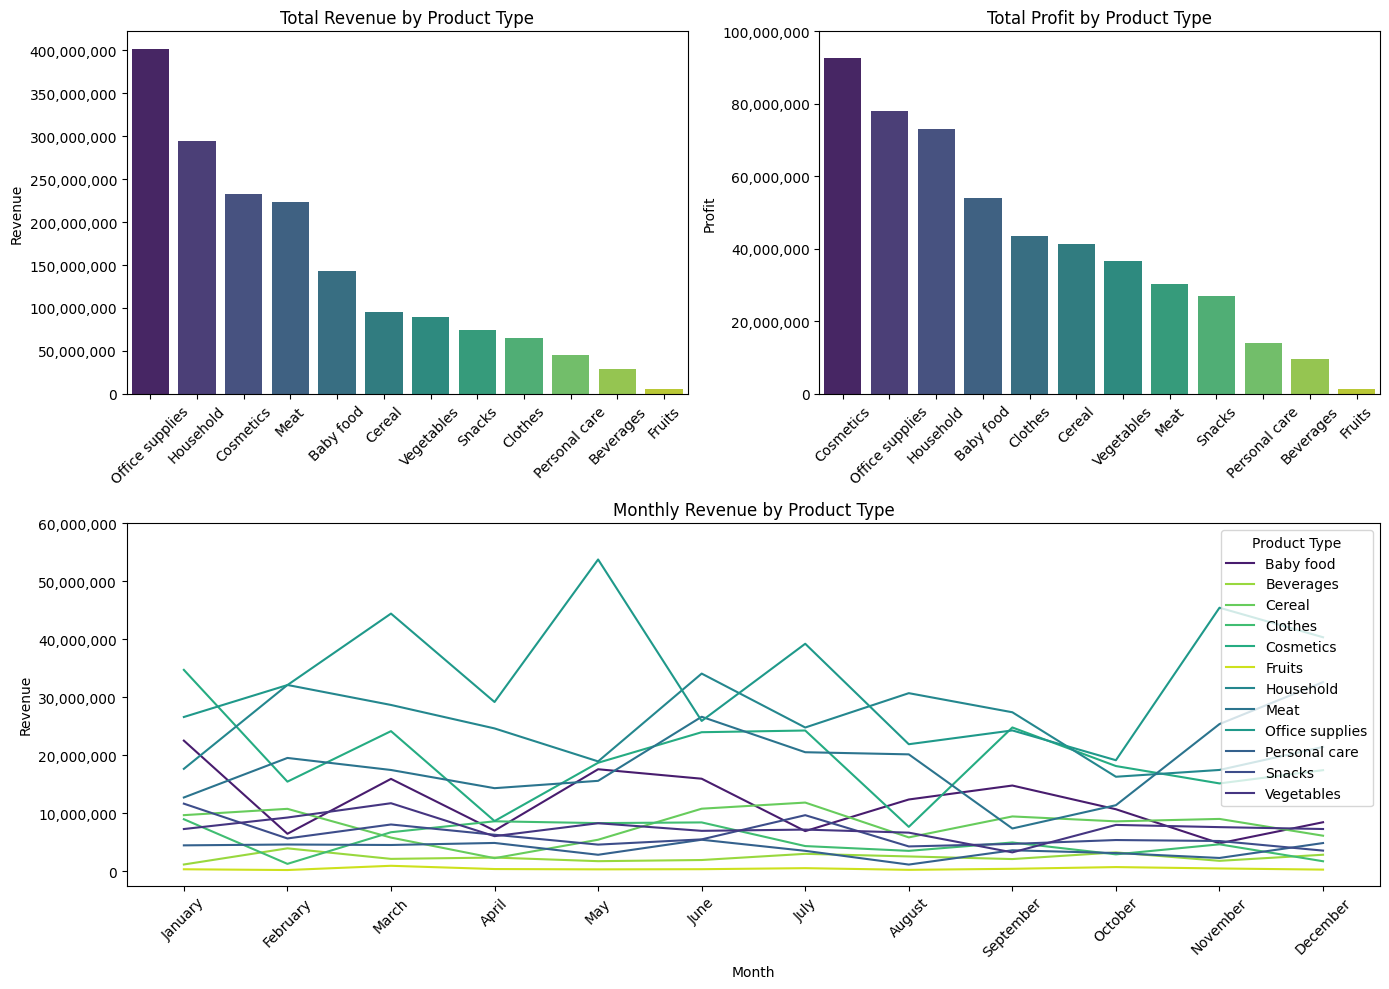

In [ ]:
category_sales = category_sales.sort_values(by="%", ascending=False).reset_index(drop=True)
category_profit = category_profit.sort_values(by="%", ascending=False).reset_index(drop=True)
category_sales["%"] = (category_sales["Revenue"] / category_sales["Revenue"].sum() * 100).round(1)
category_profit["%"] = (category_profit["Profit"] / category_profit["Profit"].sum() * 100).round(1)

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=category_sales, x="Product Type", y="Revenue", palette="viridis", ax=ax1)
ax1.set_title("Total Revenue by Product Type")
ax1.set_xlabel("")
ax1.set_ylabel("Revenue")
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=category_profit, x="Product Type", y="Profit", palette="viridis", ax=ax2)
ax2.set_title("Total Profit by Product Type")
ax2.set_xlabel("")
ax2.set_ylabel("Profit")
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim(top=max(category_profit["Profit"].max(), 100000000))


ax3 = fig.add_subplot(gs[1, :])
monthly_revenue = df.groupby(["Month name", "Product Type"])["Revenue"].sum().reset_index()
months_order = ["January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"]
monthly_revenue["Month name"] = pd.Categorical(monthly_revenue["Month name"], categories=months_order, ordered=True)
monthly_revenue = monthly_revenue.sort_values("Month name")
product_types = monthly_revenue["Product Type"].unique()
palette = sns.color_palette("viridis", len(product_types))
color_map = dict(zip(product_types, palette))

for product_type, group_data in monthly_revenue.groupby("Product Type"):
    ax3.plot(
        group_data["Month name"],
        group_data["Revenue"],
        label=product_type,
        color=color_map[product_type]
    )

ax3.set_title("Monthly Revenue by Product Type")
ax3.set_xlabel("Month")
ax3.set_ylabel("Revenue")
ax3.legend(title="Product Type")
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax3.set_ylim(top=max(monthly_revenue["Revenue"].max(), 60000000))

plt.tight_layout()
plt.show();


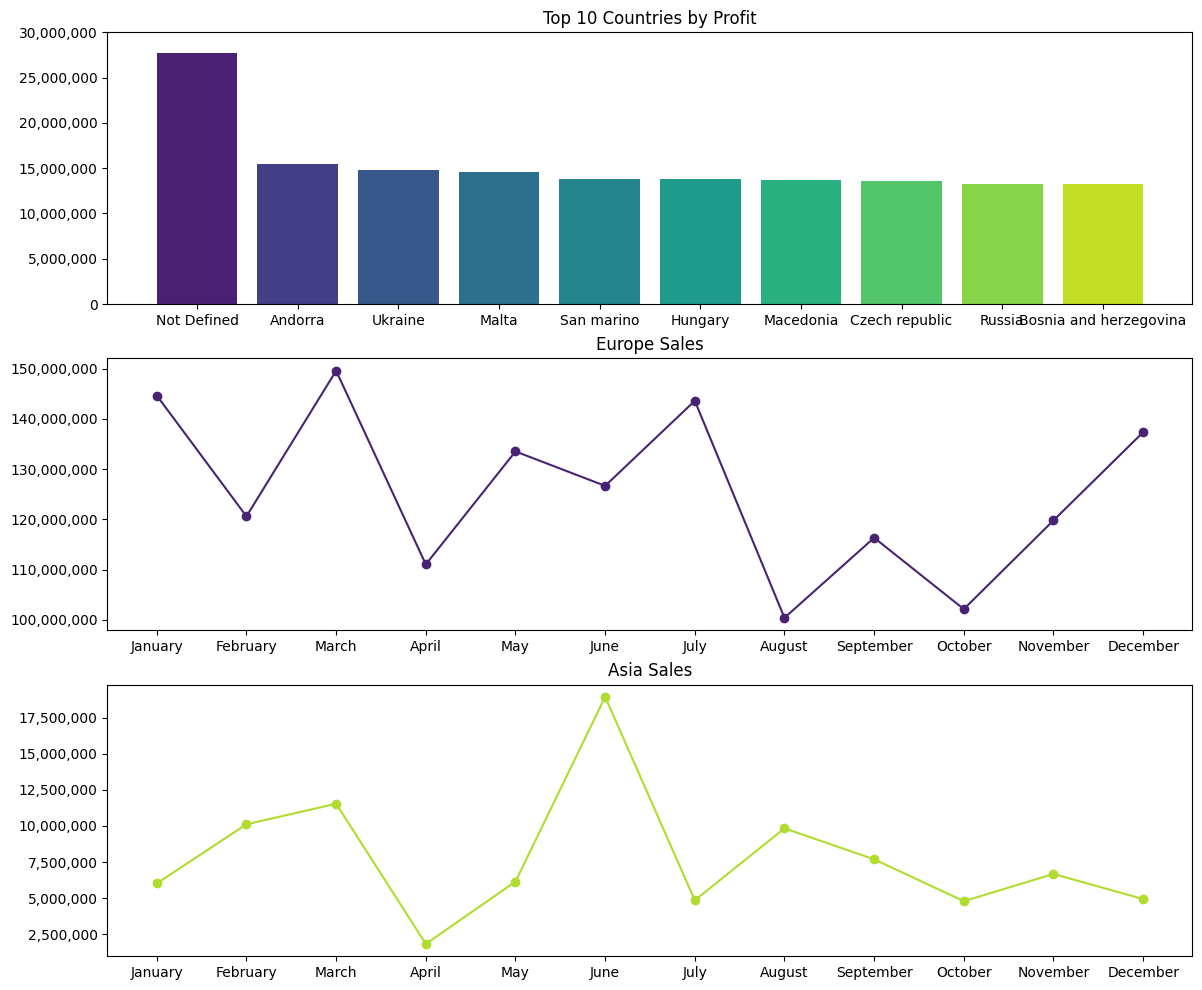

In [ ]:
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])

top_countries = countries_profit.sort_values("Profit", ascending=False).head(10)
colors = sns.color_palette("viridis", len(top_countries))
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(top_countries.index, top_countries["Profit"], color=colors)
ax1.set_title("Top 10 Countries by Profit")
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax1.set_ylim(top=max(top_countries["Profit"].max(), 30000000))


europe_sales = (df[df["region"] == "Europe"].groupby("Month name")[["Revenue"]].sum().reset_index())
europe_sales["Month name"] = pd.Categorical(europe_sales["Month name"], categories=months_order, ordered=True)
europe_sales = europe_sales.sort_values("Month name")
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(europe_sales["Month name"], europe_sales["Revenue"], marker='o', color='#482374')
ax2.set_title("Europe Sales")
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

asia_sales = (df[df["region"] == "Asia"].groupby("Month name")[["Revenue"]].sum().reset_index())
asia_sales["Month name"] = pd.Categorical(asia_sales["Month name"], categories=months_order, ordered=True)
asia_sales = asia_sales.sort_values("Month name")
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(asia_sales["Month name"], asia_sales["Revenue"], marker='o', color='#afdc2e')
ax3.set_title("Asia Sales")
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

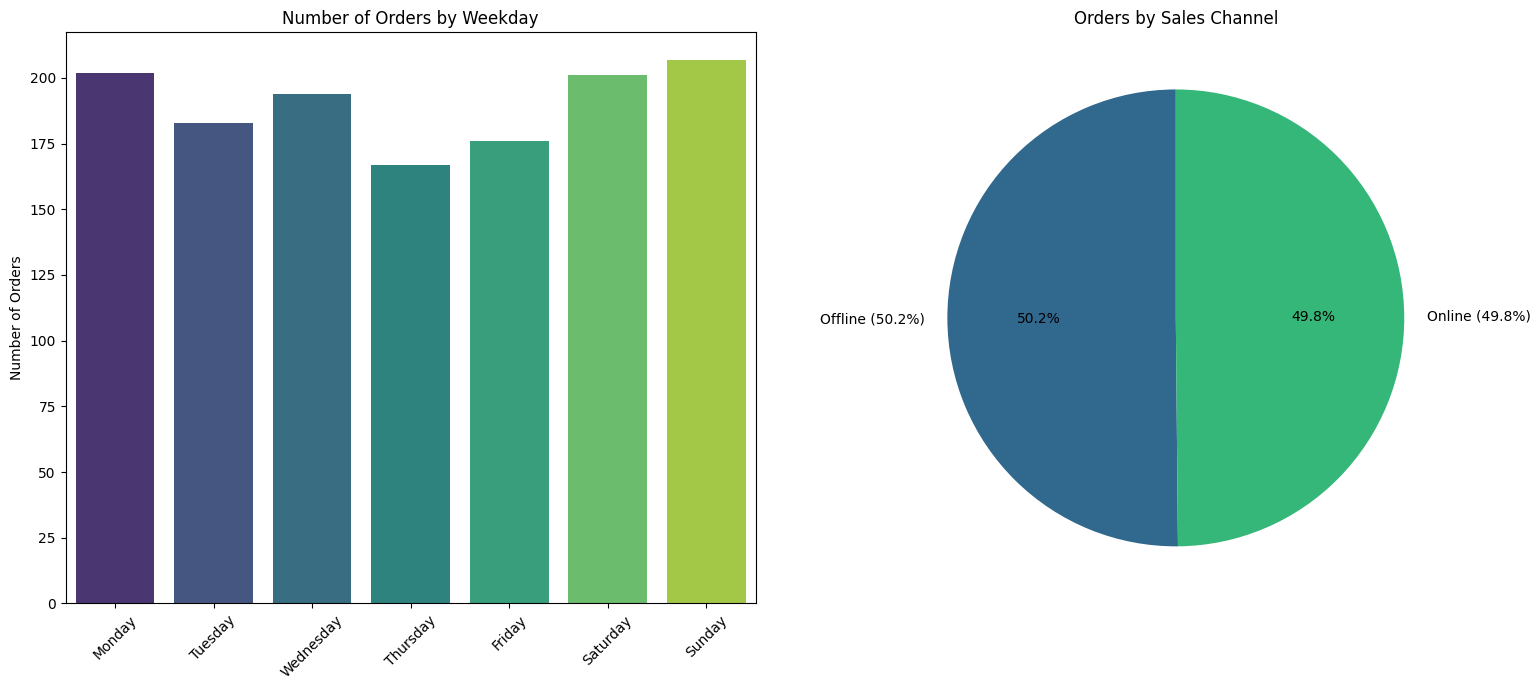

In [ ]:
weekday = weekday.reindex(week_order)
channels =df.groupby("Sales Channel")[["Order ID"]].count()
channel_percent = (channels / channels.sum() * 100).round(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.barplot(x=weekday.index, y=weekday.values, palette="viridis", ax=ax1)
ax1.set_title("Number of Orders by Weekday")
ax1.set_ylabel("Number of Orders")
ax1.set_xlabel("")
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

colors = sns.color_palette("viridis", len(channels))
ax2.pie(channels["Order ID"], labels=[
    f"{name} ({percent}%)" for name, percent in zip(channel.index, channel_percent["Order ID"])
], autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title("Orders by Sales Channel")

plt.tight_layout()
plt.show()

Аналіз продажів демонструє чітку сезонність, з піками у березні та червні та спадом у квітні, що свідчить про необхідність планування маркетингових активностей з урахуванням цих періодів.  

Найпопулярнішими категоріями товарів є office supplies, household та cosmetics, при цьому категорія cosmetics приносить найбільший прибуток. Рекомендується розглянути можливості розширення асортименту та інвестиції саме у косметичний напрямок для максимізації доходів.  

Сезонність також помітна у продажах окремих категорій, що вказує на важливість адаптації товарної політики під часові тренди.  

Щодо прибутку по країнах, значна частка припадає на невизначені географічні регіони, що підкреслює необхідність удосконалення системи звітності та ідентифікації місць продажів для точнішого аналізу ринків.  

Відзначено цікаву кореляцію між регіонами: зростання продажів у Європі супроводжується спадом в Азії, і навпаки, що може свідчити про відмінності в сезонних циклах або поведінці споживачів, і це варто враховувати при формуванні регіональних стратегій.  

Продажі за днями тижня та між онлайн та офлайн каналами майже не відрізняються, при цьому найбільша активність спостерігається у суботу, неділю та понеділок.

Також  прибутковість не залежить від часу, необхідного на відвантаження товару.